<a href="https://colab.research.google.com/github/Sep-danna/AML/blob/main/Copy_of_1A_2_HT24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Assignment 1.2 - CAVI***
Consider the model defined by Equation (10.21)-(10-23) in Bishop, for which DGM is presented below:

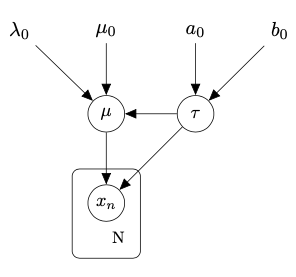

### ***Question 1.2.7:***

Implement a function that generates data points for the given model.

In [ ]:
import numpy as np
def generate_data(mu, tau, N):
  # Insert your code here

  D = np.random.normal(mu, 1/tau, N)
  return D


Set μ = 1, τ = 0.5 and generate datasets with size N=10,100,1000. Plot the histogram for each of 3
datasets you generated.



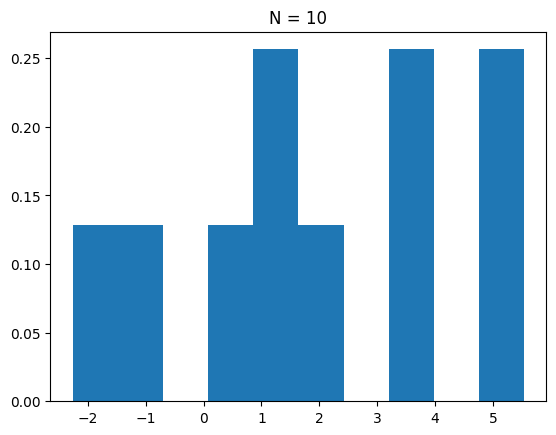

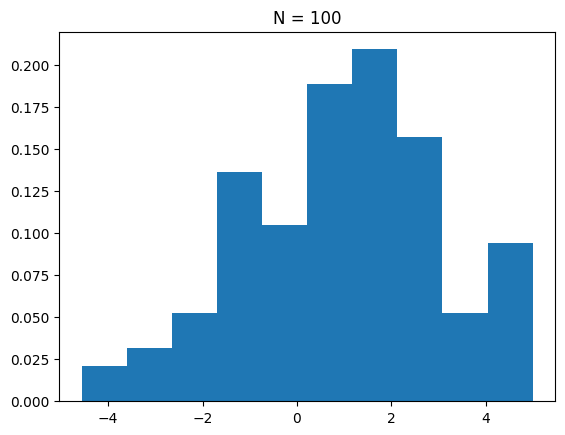

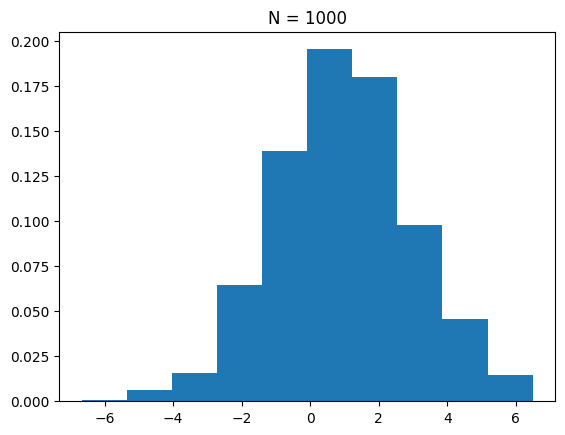

In [ ]:
mu = 1
tau = 0.5

dataset_1 = generate_data(mu, tau, 10)
dataset_2 = generate_data(mu, tau, 100)
dataset_3 = generate_data(mu, tau, 1000)

import matplotlib.pyplot as plt
# Visulaize the datasets via histograms
# Insert your code here
plt.hist(dataset_1, density=True)
plt.title("N = 10")
plt.show()
plt.title("N = 100")
plt.hist(dataset_2, density=True)
plt.show()
plt.title("N = 1000")
plt.hist(dataset_3, density=True)
plt.show()



### ***Question 1.2.8:***

Find ML estimates of the variables μ and τ

In [ ]:
def ML_est(data):
  # insert your code
  mu_ml = np.mean(data)
  tau_ml = 1/np.var(data)
  return mu_ml, tau_ml

### ***Question 1.2.9:***

What is the exact posterior? First derive it in closed form, and then implement a function that computes it for the given parameters:


In [ ]:
def compute_exact_posterior(D, a_0, b_0, mu_0, lambda_0):
  # your implementation
  N = len(D)

  mu_N = (lambda_0 * mu_0 + np.sum(D)) / (lambda_0 + N)
  lambda_N = lambda_0 + N

  a_N = a_0 + (N+1)/2
  b_N = b_0 + 0.5 * (np.sum(D**2) + lambda_0 * mu_0**2 - (mu_0 * lambda_0 + np.sum(D))**2 / (lambda_0 + N))

  exact_post_dist_parameters = (a_N, b_N, mu_N, lambda_N)
  return exact_post_dist_parameters

### ***Question 1.2.10:***
You will implement the VI algorithm for the variational distribution in Equation (10.24) in Bishop. Start with introducing the prior parameters:

In [ ]:
# prior parameters
mu_0 = 1
lambda_0 = 1
a_0 = 1
b_0 = 1

Continue with a helper function that computes ELBO:


In [ ]:
from scipy.special import digamma, gammaln, gamma

def compute_elbo (D, a_0, b_0, mu_0, lambda_0, a_N , b_N, mu_N, lambda_N):
  # given the prior and posterior parameters together with the data,
  # compute ELBO here
  N = len(D)
  x_bar = np.mean(D)
  E_tau = a_N/b_N
  E_log_tau = digamma(a_N) - np.log(b_N)

  E_log_p_D_given_mu_tau = (
      0.5 * N * (E_log_tau - np.log(2 * np.pi))
      - 0.5 * E_tau * (np.sum(D**2) - 2 * np.sum(D*x_bar) + x_bar + N/(lambda_N * E_tau))
      )

  E_log_p_mu_given_tau = (
      0.5 * E_log_tau + 0.5 * np.log(lambda_0) - 0.5 * np.log(2*np.pi)
      - 0.5 * lambda_0 * E_tau * ((x_bar**2 + 1/(lambda_N * E_tau)) - 2 * x_bar * mu_0 + mu_0**2)
  )

  E_log_p_tau = (a_0 * np.log(b_0) - gammaln(a_0) + (a_0 - 1) * E_log_tau - b_0 * E_tau)

  E_log_p_D_mu_tau = E_log_p_D_given_mu_tau + E_log_p_mu_given_tau + E_log_p_tau

  E_log_q_mu_given_tau = 0.5*(1 + np.log(2*np.pi) - np.log(lambda_N) + E_log_tau)

  E_log_q_tau = a_N - np.log(b_N) + gammaln(a_N) + (1 - a_N) * digamma(a_N)

  E_log_q_mu_tau = E_log_q_mu_given_tau + E_log_q_tau

  elbo = E_log_p_D_mu_tau + E_log_q_mu_tau
  return elbo


Now, implement the CAVI algorithm:

In [ ]:
def CAVI(D, a_0, b_0, mu_0, lambda_0):
  # make an initial guess for the expected value of tau
  initial_guess_exp_tau = 1
  N = len(D)
  tol = 1e-5
  elbos = []
  prev_elbo = float('-inf')
  iterations = 100
  x_bar = np.mean(D)

  # CAVI iterations ...
  for i in range(iterations-1):
    mu_N = (lambda_0 * mu_0 + N * x_bar) / (lambda_0 + N)
    lambda_N = (lambda_0 + N) * initial_guess_exp_tau

    a_N = a_0 + (N+1) / 2
    b_N = b_0 + 0.5 * (np.sum(D**2) - 2 * x_bar * np.sum(D) + x_bar**2 + 1/(lambda_N * initial_guess_exp_tau) - lambda_0 *(x_bar**2 + 1/(lambda_N * initial_guess_exp_tau) - 2 * x_bar * mu_0 + mu_0**2))

    # save ELBO for each iteration, plot them afterwards to show convergence
    elbo = compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_N, b_N, mu_N, lambda_N)
    elbos.append(elbo)

    if abs(elbo - prev_elbo) < tol:
      break

    a_0 = a_N
    b_0 = b_N
    mu_0 = mu_N
    lambda_0 = lambda_N
    initial_guess_exp_tau = a_N / b_N
    prev_elbo = elbo

  return a_N, b_N, mu_N, lambda_N, elbos

Run the VI algorithm on the datasets. Compare the inferred variational
distribution with the exact posterior and the ML estimate. Visualize the results and discuss your
findings.


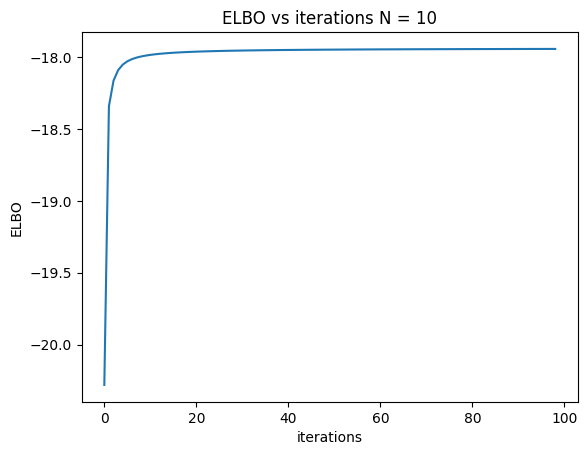

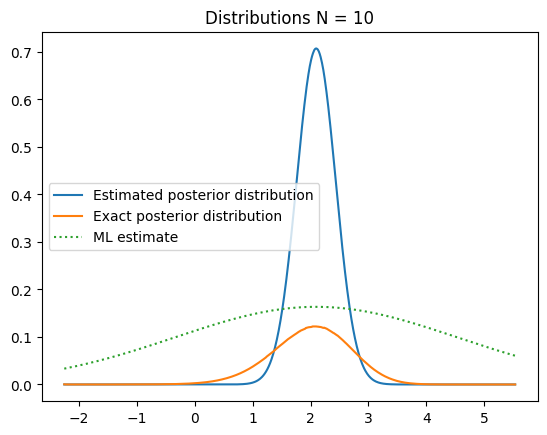

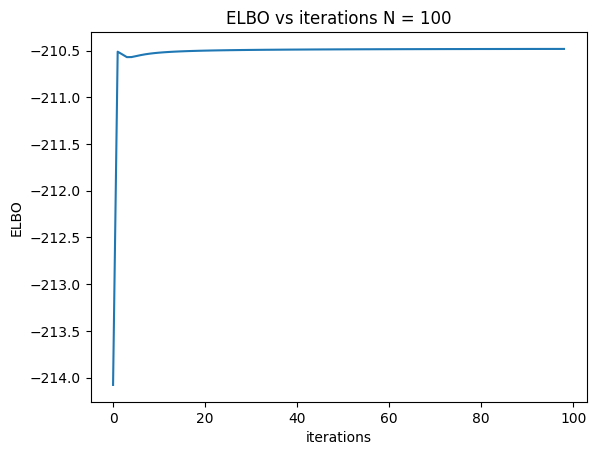

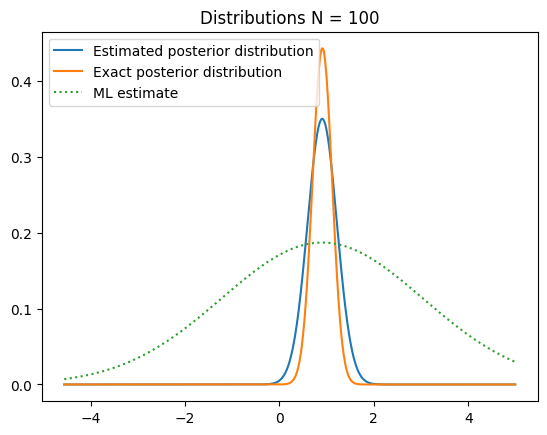

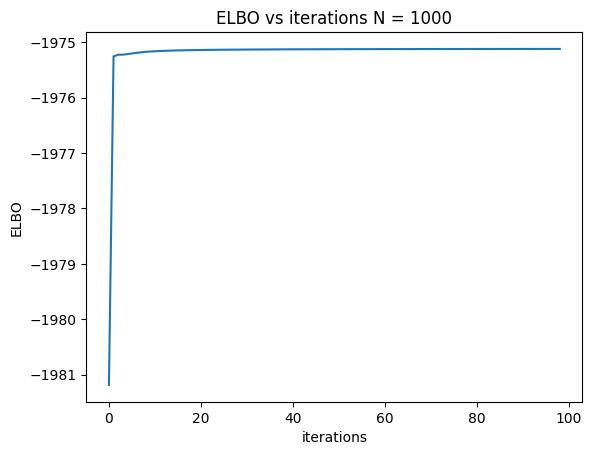

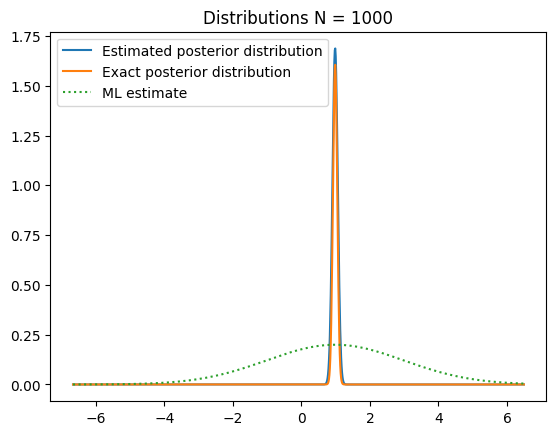

In [ ]:
import scipy.stats as ss
def calculate_posterior(D, a_N, b_N, mu_N, lambda_N):
  N = len(D)
  gamma_pdf = np.sort(np.random.gamma(a_N, 1/b_N, N))
  normal_pdf = np.sqrt(gamma_pdf * lambda_N / (2 * np.pi)) * np.exp(-gamma_pdf * lambda_N * (x - mu_N)**2 / 2)
  return gamma_pdf * normal_pdf


def normalpdf(D, mu, tau):
  normal = np.sqrt(tau / (2 * np.pi)) * np.exp(-tau / 2 * (D - mu)**2)
  return normal

datasets = [dataset_1, dataset_2, dataset_3]

for dataset in datasets:
  mu_ml, tau_ml = ML_est(dataset)
  a_N, b_N, mu_N, lambda_N, elbos = CAVI(dataset, a_0, b_0, mu_0, lambda_0)
  plt.plot(elbos)
  plt.xlabel('iterations')
  plt.ylabel('ELBO')
  plt.title(f'ELBO vs iterations N = {len(dataset)}')
  plt.show()
  a_exact, b_exact, mu_exact, lambda_exact = compute_exact_posterior(dataset, a_0, b_0, mu_0, lambda_0)

  x = np.linspace(min(dataset), max(dataset), 1000)

  plt.plot(x, calculate_posterior(x, a_N, b_N, mu_N, lambda_N), label= "Estimated posterior distribution")
  plt.plot(x, calculate_posterior(x, a_exact, b_exact, mu_exact, lambda_exact), label = "Exact posterior distribution")
  plt.plot(x, normalpdf(x, mu_ml, tau_ml), label = "ML estimate", linestyle=":")
  plt.title(f"Distributions N = {len(dataset)}")
  plt.legend()
  plt.show()

# Example flow for dataset_2:
  ##  mu_ml, tau_ml = ML_est(dataset_2)
  ##  a_N, b_N, mu_N, lambda_N, elbos = CAVI(dataset_2, a_0, b_0, mu_0, lambda_0)
  ##  plot elbos, show convergence
  ##  exact_post_dist_param = compute_exact_posterior(dataset_2, a_0, b_0, mu_0, lambda_0)
  ##  compare exact_post_dist with the CAVI result ( = q(a_N, b_N, mu_N, lambda_N) ) using for ex. contour plots, show also ML estimate on this plot